## M. Amintoosi
## کاوش الگوهای پرتکرار
استخراج قوانین انجمنی

In [116]:
import pandas as pd
import numpy as np
# from orangecontrib.associate.fpgrowth import *
from itertools import tee
from tqdm import tqdm
import networkx as nx
import math 
from sklearn import preprocessing
import ml_metrics
import recmetrics

df = pd.read_excel(r'data/403.xlsx') 
# df = pd.read_excel(r'results/bestPlants_min_freq_10.xlsx', header=None) 
# bf_plants = list(df[0])
# print (list(df[0]))
# metabolitNames = df.head(0).to_string()
plantNames = list(df.head(0)) #df.keys()#
len(plantNames)

403

In [2]:
numpy_matrix = df.values
d =  numpy_matrix.transpose()
T = [[x for x in row if str(x) != 'nan'] for row in d]
# T = [[str(i)[3:] for i in row ] for row in d]
# T = [[int(i) for i in row if i != ''] for row in T]
print(T[0][:20])
n_plants = len(T)
n_plants

['C00001036', 'C00002647', 'C00005548', 'C00005872', 'C00008210', 'C00008817', 'C00013297', 'C00013867', 'C00013974', 'C00014320', 'C00046784']


403

In [3]:
# مشخص کردن تعداد متابولیت‌های مجزا
from itertools import chain
newlist = list(chain(*T))
print(len(np.unique(newlist)))
newlist[0]

7416


'C00001036'

## ایجاد ماتریس مجاروتی گرافی که نودهای آن گیاهان و وزن لبه ها تعداد متابولیت های مشترک است

ابتدا کیسه کلمات صفر و یکی را ایجاد می‌کنیم

In [4]:
corpus = [None] * len(T)
for i in range(len(T)):
    listToStr = ' '.join([str(elem) for elem in T[i]]) 
    corpus[i] = listToStr
print(type(corpus))
print(corpus[0])
print(len(corpus[0]))

<class 'list'>
C00001036 C00002647 C00005548 C00005872 C00008210 C00008817 C00013297 C00013867 C00013974 C00014320 C00046784
109


In [5]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(token_pattern = r"(?u)\b\w+\b")
X = vectorizer.fit_transform(corpus)
print(X.shape)
# print(X.toarray())
bow = X.toarray()
print(sum(bow[0] & bow[2]))
featureNames = vectorizer.get_feature_names()
type(featureNames)
print(featureNames[:5])

(403, 7416)
1
['c00000001', 'c00000003', 'c00000004', 'c00000005', 'c00000007']


In [6]:
# ایجاد ماتریس مجاورتی
M = np.zeros((n_plants,n_plants))
for i in range(n_plants):
    for j in range(n_plants):
        M[i,j] = sum(bow[i] & bow[j])

In [7]:
G_fileName = "results/M"+".npy"
with open(G_fileName, 'wb') as f:
  np.save(f,M)

In [8]:
# minFreq = 10
# itemsets = frequent_itemsets(T, minFreq)
# freqIS_list = list(itemsets)
# n_freqIS = len(freqIS_list)
# print(n_freqIS)

In [9]:
# minFreq = 10
# G_fileName = "results/"+str(minFreq)+"_G"+".npy"
# with open(G_fileName, 'rb') as f:
# #   G = np.load(f)
# #   Gw = np.load(f)
# #   featureNames = np.load(f)
#   plantNames = np.load(f)
# #   bow = np.load(f)

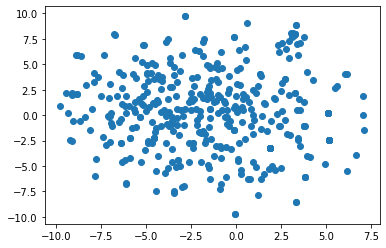

In [10]:
from sklearn.manifold import TSNE

#  TSNE(, perplexity=perplexity,
#                  method="barnes_hut", random_state=42, n_iter=n_iter)
tsne = TSNE(n_components=2, metric='precomputed')
distGraph = 1/(M+0.01)
X_2d = tsne.fit_transform(distGraph)
target_ids = range(2)

from matplotlib import pyplot as plt
# plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
# for i, c, label in zip(target_ids, colors, digits.target_names):
#     plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=c, label=label)
# plt.legend()
plt.scatter(X_2d[:, 0], X_2d[:, 1],label=featureNames)
plt.show()                 

In [11]:
# plt.figure(figsize=(16, 5))
# plt.scatter(X_2d[:, 0], X_2d[:, 1])
# for i in range(10):
#     plt.scatter(X_2d[bf_plants[i], 0], X_2d[bf_plants[i], 1],label=plantNames[bf_plants[i]],c=colors[i])
# plt.legend()
# plt.show()                 

In [12]:
import networkx as nx
G = nx.Graph(M)

In [13]:
print(nx.is_connected(G))
conComp = list(nx.connected_components(G))
print(len(conComp))

False
43


In [14]:
n_con_comp = [len(x) for x in conComp]
idx = np.argsort(n_con_comp)
maxIdx = idx[-1]
print(maxIdx,n_con_comp[maxIdx])
con_comp_indices = conComp[maxIdx]
# con_comp_indices

0 360


In [15]:
subG = G.subgraph(nodes=con_comp_indices)
# nx.draw_shell(subG)
# nx.draw_networkx(subG)

In [16]:
 len(subG.nodes())

360

In [17]:
def graph_features(G,normalize=True):
    df= pd.DataFrame(index = G.nodes())
    deg = G.degree()
    deg_list = np.zeros((len(deg)))
    for i,x in enumerate(G.degree()):
        deg_list[i] = x[1]

    df['degree'] = deg_list #pd.Series(deg_list)
    df['degree_cent'] = pd.Series(nx.degree_centrality(G))
    df['betweenness'] = pd.Series(nx.betweenness_centrality(G))
    df['closeness'] = pd.Series(nx.closeness_centrality(G))
    df['eccentricity'] = pd.Series(nx.eccentricity(G))
    df['eigenvector'] = pd.Series(nx.eigenvector_centrality(G))
    if(normalize):
        min_max_scaler = preprocessing.MinMaxScaler()
        numpy_matrix = df.values
        X = min_max_scaler.fit_transform(numpy_matrix)
        for i,col in enumerate(df.columns):
            df.loc[:, col] = X[:,i]

    return df

In [18]:
gf_df = graph_features(subG) # graph features data frame

# محاسبه مجموع ویژگی ها
features_sum = gf_df.sum(axis=1)
gf_df['features_sum'] = features_sum

gf_df

,degree,degree_cent,betweenness,closeness,eccentricity,eigenvector,features_sum
0,0.257511,0.257511,0.018151,0.496893,0.0,0.307056,1.337121
1,0.154506,0.154506,0.002747,0.419258,0.0,0.187298,0.918315
2,0.133047,0.133047,0.002513,0.379314,0.0,0.155446,0.803368
3,0.060086,0.060086,0.001295,0.361737,0.5,0.079463,1.062667
4,0.579399,0.579399,0.315096,0.681203,0.0,0.675083,2.830180
...,...,...,...,...,...,...,...
397,0.218884,0.218884,0.028948,0.485140,0.0,0.283549,1.235405
398,0.025751,0.025751,0.000000,0.311121,0.5,0.037245,0.899868
399,0.025751,0.025751,0.000000,0.311121,0.5,0.037245,0.899868
401,0.412017,0.412017,0.058770,0.596176,0.0,0.530014,2.008995


In [19]:
# مرتب سازی بر حسب مجموع ویژگی ها
indices = gf_df['features_sum']#.argsort()#[::-1]
# print(indices.sort_values(ascending=False))
plants_numbers_desc = indices.sort_values(ascending=False).index
# print((plants_numbers_desc[:100].values))
plants_order_by_features = df.keys()[plants_numbers_desc.values].values
# plants_order_by_features
# plantNames[plants_numbers_desc[:10].values]
# plantNames[plants_numbers_desc[:10].values]

In [20]:
# df[df.keys()[plants_numbers_desc[:10].values]]

In [21]:
# لیست اندیس گیاهانی که حذف شده اند
gf_df.index ^ df.index

Int64Index([  7,   9,  13,  16,  25,  30,  39,  46,  47,  63,
            ...
            617, 618, 619, 620, 621, 622, 623, 624, 625, 626],
           dtype='int64', length=267)

In [22]:
# خواندن فایل AC

ac_df = pd.read_excel(r'data/AC complete network 27-06-98 .xlsx')
ac_df = ac_df.drop(columns=['interaction'])
ac_df.head()

,Speciea,Metabolit
0,Arabidopsis thaliana,C00000113
1,Begonia nantoensis,C00000113
2,Beta vulgaris,C00000113
3,Cucumis sativus,C00000113
4,Nicotiana tabacum,C00000113


In [23]:
# ac_df.groupby('Speciea').count()
ac_df.groupby('Speciea').count().sort_values(by='Metabolit',ascending=False)

,Metabolit
Speciea,
Annona muricata,14
Arabidopsis thaliana,14
Citrus spp.,13
Morus alba,13
Citrus aurantium,11
...,...
Euphorbia paralias,1
Euphorbia peplus,1
Euphorbia portlandica,1


In [33]:
# AC_plants_index_order_by_metabolit_numbers = ac_df.groupby('Speciea').count().sort_values(by='Metabolit',ascending=False)
# AC_plants_index_order_by_metabolit_numbers

In [29]:
AC_plants_order_by_metabolit_numbers = ac_df.groupby('Speciea').count().sort_values(by='Metabolit',ascending=False).index.values

array(['Annona muricata', 'Arabidopsis thaliana', 'Citrus spp.', ...,
       'Euphorbia portlandica', 'Euphorbia segetalis ',
       'Zollernia paraensis'], dtype=object)

In [37]:
intersect = set(AC_plants_order_by_metabolit_numbers) & set(plants_order_by_features)
print(len(intersect))
print(intersect)
print(type(AC_plants_order_by_metabolit_numbers))
print(AC_plants_order_by_metabolit_numbers.shape,plants_order_by_features.shape)

71
{'Eucommia ulmoides', 'Brassica oleracea', 'Fagara tessmannii', 'Perilla frutescens', 'Plantago major', 'Hibiscus taiwanensis', 'Trifolium repens', 'Poncirus trifoliata', 'Annona montana', 'Panax ginseng', 'Rhus chinensis ', 'Salvia officinalis', 'Annona squamosa', 'Porcelia macrocarpa', 'Ziziphus jujuba', 'Allium cepa', 'Theobroma cacao', 'Rosmarinus officinalis', 'Nigella sativa', 'Juniperus phoenicea', 'Citrus unshiu', 'Thalictrum glandulosissimum', 'Oricia suaveolens', 'Tanacetum polycephalum', 'Glycyrrhiza glabra', 'Datura stramonium', 'Strychnos nux-vomica', 'Camellia sinensis', 'Chelidonium majus', 'Hibiscus sabdariffa', 'Punica granatum', 'Capsicum annuum', 'Tribulus terrestris', 'Crataegus pinnatifida', 'Achillea millefolium', 'Sophora japonica', 'Piper nigrum', 'Mansonia gagei', 'Chamaecyparis obtusa', 'Ardisia colorata', 'Asparagus cochinchinensis', 'Garcinia mangostana', 'Rubia cordifolia', 'Salvia dominica', 'Sophora tonkinensis', 'Trifolium subterraneum', 'Trifolium pr

In [120]:
# intersect = set(AC_plants_order_by_metabolit_numbers) & set(plants_order_by_features)
# print(len(intersect))
# print(intersect)
import recmetrics
pred_mark_features = []
for K in np.arange(1, 30,2):
    pred_mark_features.extend([recmetrics.mark(AC_plants_order_by_metabolit_numbers, plants_order_by_features[:100], k=K)])
# pred_mark_features
pred_mapk_features = []
for K in np.arange(1, 30,2):
    pred_mapk_features.extend([ml_metrics.mapk(AC_plants_order_by_metabolit_numbers, plants_order_by_features[:100], k=K)])


In [119]:
fim_df = pd.read_excel(r'results/bestPlants_min_freq_10.xlsx',header=None) 
# fim_df[1].values
# plants_order_by_fim = fim_df['']

pred_mark_fim = []
for K in np.arange(1, 30,2):
    pred_mark_fim.extend([recmetrics.mark(AC_plants_order_by_metabolit_numbers, fim_df[1].values, k=K)])
# pred_mark_fim
pred_mapk_fim = []
for K in np.arange(1, 30,2):
    pred_mapk_fim.extend([ml_metrics.mapk(AC_plants_order_by_metabolit_numbers, fim_df[1].values, k=K)])


In [129]:
rt_df = pd.read_excel('data/RT-complete-network.xlsx')
rt_df.drop(columns=['pm'],inplace=True)
rt_df.head()
RT_plants_order_by_metabolit_numbers = rt_df.groupby('Plant').count().sort_values(by='Metabolite',ascending=False).index.values
print(len(RT_plants_order_by_metabolit_numbers))
intersect = set(AC_plants_order_by_metabolit_numbers) & set(RT_plants_order_by_metabolit_numbers)
print(len(intersect))
# print(intersect)
# print(type(AC_plants_order_by_metabolit_numbers))
# print(AC_plants_order_by_metabolit_numbers.shape,plants_order_by_features.shape)

pred_mark_rt = []
for K in np.arange(1, 30,2):
    pred_mark_rt.extend([recmetrics.mark(AC_plants_order_by_metabolit_numbers, RT_plants_order_by_metabolit_numbers, k=K)])
pred_mapk_rt = []
for K in np.arange(1, 30,2):
    pred_mapk_rt.extend([ml_metrics.mapk(AC_plants_order_by_metabolit_numbers, RT_plants_order_by_metabolit_numbers, k=K)])
# pred_mark_rt


403
74


In [1]:
# RT_plants_order_by_metabolit_numbers.tolist()
# AC_plants_order_by_metabolit_numbers.tolist()

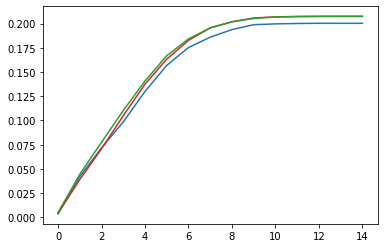

In [106]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(pred_mark_features, color='tab:blue')
ax.plot(pred_mark_fim, color='tab:red')
ax.plot(pred_mark_rt, color='tab:green')

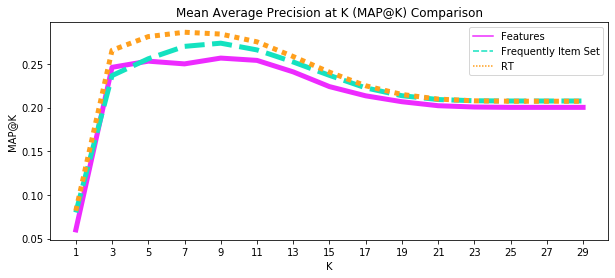

In [125]:
mapk_scores = [pred_mapk_features, pred_mapk_fim, pred_mapk_rt]
index = np.arange(1,30,2)
names = ['Features', 'Frequently Item Set', 'RT']

fig = plt.figure(figsize=(10, 4))
recmetrics.mapk_plot(mapk_scores, model_names=names, k_range=index)

In [127]:
for i in range(len(pred_mapk_fim)):
    print("{:2.3f}  {:2.3f}".format(pred_mapk_features[i],pred_mapk_fim[i]))

0.060  0.080
0.246  0.237
0.253  0.256
0.250  0.270
0.257  0.274
0.254  0.266
0.241  0.252
0.224  0.237
0.213  0.223
0.207  0.214
0.202  0.209
0.201  0.208
0.200  0.208
0.200  0.208
0.200  0.208


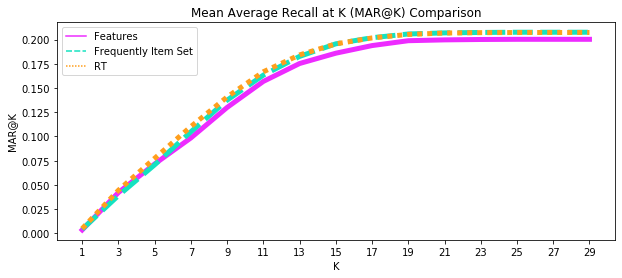

In [122]:
mark_scores = [pred_mark_features, pred_mark_fim, pred_mark_rt]
index = np.arange(1,30,2)
names = ['Features', 'Frequently Item Set', 'RT']

fig = plt.figure(figsize=(10, 4))
recmetrics.mark_plot(mark_scores, model_names=names, k_range=index)

In [126]:
for i in range(len(pred_mark_fim)):
    print("{:2.3f}  {:2.3f}".format(pred_mark_features[i],pred_mark_fim[i]))
# [pred_mark_fim,pred_mark_rt]

0.004  0.004
0.042  0.039
0.072  0.071
0.098  0.105
0.130  0.137
0.157  0.163
0.175  0.183
0.186  0.196
0.194  0.202
0.199  0.206
0.200  0.207
0.200  0.207
0.200  0.208
0.200  0.208
0.200  0.208


In [27]:
copy_subG = subG.copy()
copy_subG.remove_edges_from(min_cut_edges)

In [28]:
conComp = list(nx.connected_components(copy_subG))
subG = D.subgraph(nodes=list(conComp[0]))
# conComp

NameError: name 'D' is not defined

In [63]:
# در هر دفعه فقط یک نود جدا میشه. اول ۱۵۰ حالا ۲۲۱.
min_cut_edges = list(nx.minimum_edge_cut(subG))
print(min_cut_edges)
copy2_subG = subG.copy()
copy2_subG.remove_edges_from(min_cut_edges)

[(221, 103), (221, 40), (221, 393), (221, 84), (221, 308), (221, 171), (221, 24), (221, 314), (221, 379)]


In [84]:
# type(cut_subG)
# nx.draw_networkx(copy_subG)
# plantNames[150]
import statistics
def amar(a_dic):
    vals = [a_dic[k] for k in a_dic]
    kamine = min(vals)
    bishine = max(vals)
    miangin = statistics.mean(vals)
    return [kamine,bishine,miangin]

d_cen = nx.degree_centrality(D)
# min(d_cen),max(d_cen),statistics.mean(d_cen)
print(amar(d_cen))

[0.0, 0.527363184079602, 0.1187857239855314]


In [85]:
b_cen = nx.betweenness_centrality(D)
print(amar(b_cen))

[0.0, 0.015331981254820626, 0.0008027164906271903]


In [87]:
c_cen = nx.closeness_centrality(D)
print(amar(c_cen))

[0.0, 0.5486491592669563, 0.2508078697418403]


In [90]:
data = c_cen.copy()
import operator
sorted(data.items(), key= operator.itemgetter(1) ,reverse=True)[:10]

[(50, 0.5486491592669563),
 (53, 0.545198535623768),
 (40, 0.5318194304550865),
 (310, 0.5114251750099063),
 (208, 0.49114202359308273),
 (183, 0.4897546167467746),
 (195, 0.48700318631561296),
 (179, 0.4856390317320958),
 (279, 0.4789313102993321),
 (49, 0.47499488857084443)]

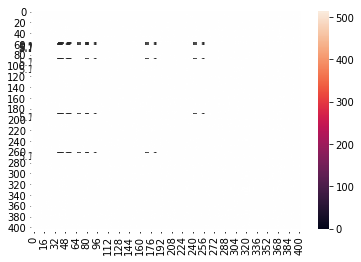

In [26]:
# import seaborn as sns
# sns.heatmap(G, annot=True)

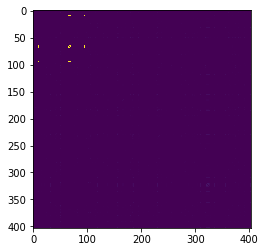

In [27]:
%matplotlib inline 
from matplotlib import pyplot as plt
plt.imshow(G, interpolation='nearest')
plt.show()